4422102/4422102 [==============================] - 1s 0us/step


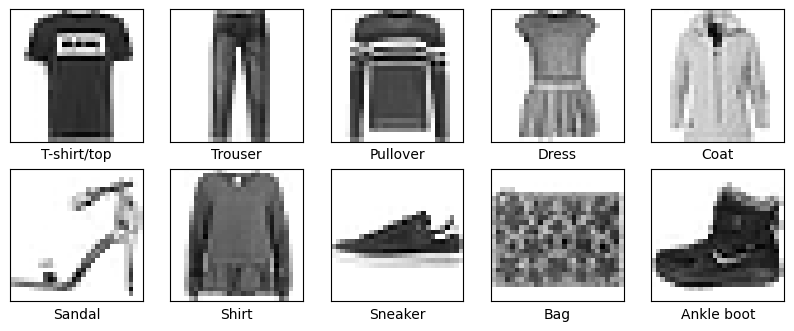

In [8]:
#importing essential libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

#loading the datasets

(x_training_set, y_training_set), (x_testing_set, y_testing_set) = fashion_mnist.load_data()

#storing different classes in a list

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#function definition to plot the one image from different classes

def plot_img(images, labels, classes):
  image_list = [] #list to store one image from each class
  class_num = len(classes)

  for i in range(class_num):
    indx = np.where(labels == i)[0][0]
    image_list.append(images[indx])

  #plotting the images

  plt.figure(figsize = (10,10))
  for i in range(class_num):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_list[i], cmap=plt.cm.binary)
    plt.xlabel(classes[i])
  plt.show()


#calling the function

plot_img(x_training_set, y_training_set, classes)

In [9]:
#splitting the data for cross validation

x_validation_set = x_training_set[50000:]
y_validation_set = y_training_set[50000:]     # validation set has 10000 data

x_training_set = x_training_set[:50000]
y_training_set = y_training_set[:50000]


#vactorising the data

x_training_set = x_training_set.reshape(x_training_set.shape[0], 784)  #28x28 pixels = 784
x_testing_set = x_testing_set.reshape(x_testing_set.shape[0], 784)
x_validation_set = x_validation_set.reshape(x_validation_set.shape[0], 784)

#normalising the data

x_train = x_training_set/255  # since, pixel range from 0 to 255
x_test = x_testing_set/255
x_valid = x_validation_set/255

#one hot encoding for labels to represent categorical variables as numerical values

y_train = to_categorical(y_training_set)
y_test = to_categorical(y_testing_set)
y_valid = to_categorical(y_validation_set)


#default_x_train = x_train
#default_y_train = y_train

# some useful functions

#for hidden layer
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradient_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

#for output layer
def softmax(x):
  exponents = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exponents / np.sum(exponents, axis=1, keepdims=True)


#loss function(cross-entropy)
def loss_func(x,y):
  L = -np.mean(np.sum(x * np.log(y), axis=1))
  return L

In [15]:
#class definition

class Network:
    def __init__(self, neuron_sizes, weight_initialiser, activation_function, momentum):

        self.train_loss_sgd = []
        self.train_loss_momentum = []


        self.total_layers = len(neuron_sizes)
        self.momentum = momentum

        # Initializing the weights and biases
        # After initializing, store weights and biases in separate lists
        if weight_initialiser == 'xavier':
            if activation_function != 'relu':
                self.Weights = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
                self.biases = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(1, neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
            else:
                self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
                self.biases = [np.random.randn(1, neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
        else:
            self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1]) for i in range(self.total_layers-1)]
            self.biases = [np.random.randn(1, neuron_sizes[i+1])*0.05 for i in range(self.total_layers-1)]

        # Initializing momentum weights and biases
        self.Weights_moment = [np.zeros_like(x) for x in self.Weights]
        self.biases_moment = [np.zeros_like(x) for x in self.biases]

        # Initializing Nesterov momentum adjusted weights and biases
        self.momentum_adjusted_Weights = None
        self.momentum_adjusted_biases = None

    # Defining function for forward propagation
    def forward_prop(self, X):
        self.pre_activations_A = [None]*(self.total_layers)  # List to store the pre-activations
        self.activations_H = [X]  # List to store the activations

        for i in range(self.total_layers-1):
            self.pre_activations_A[i+1] = np.dot(self.activations_H[i], self.Weights[i]) + self.biases[i]
            if i == self.total_layers-2:  # For output layer: activation function = softmax
                h = softmax(self.pre_activations_A[i+1])
                self.activations_H.append(h)
            else:  # For hidden layers: activation function = sigmoid
                h = sigmoid(self.pre_activations_A[i+1])
                self.activations_H.append(h)
        return self.activations_H[-1]

    #defining the training method for stochastic gradient method
    def train_sgd(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):
                # Forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                # Applying backpropagation algorithm
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.biases[j-1] - learning_rate_eta * gradient_b

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_sgd.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            wandb.log({'val-accuracy':valid_accuracy*100})


        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # Defining the momentum-based gradient descent training method
    def train_momentum(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):

                #performing the forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                #performing the back-propagation
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of momentum
                    self.Weights_moment[j-1] = self.momentum * self.Weights_moment[j-1] + learning_rate_eta * gradient_W
                    self.biases_moment[j-1] = self.momentum * self.biases_moment[j-1] + learning_rate_eta * gradient_b

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - self.Weights_moment[j-1]
                    self.biases[j-1] = self.biases[j-1] - self.biases_moment[j-1]

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_momentum.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            wandb.log({'val-accuracy':valid_accuracy*100})

        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    #defining the training method for nesterov accelerated gradient descent method
    def train_nag(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            for i in range(0, x_train.shape[0], batch_size):
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]

                # Nesterov accelerated gradient descent: lookahead
                '''
                self.momentum_adjusted_Weights = [self.Weights[j-1] - self.momentum * self.Weights_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]
                self.momentum_adjusted_biases = [self.biases[j-1] - self.momentum * self.biases_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]'''

                self.momentum_adjusted_Weights = [self.Weights[j] - self.momentum * self.Weights_moment[j] for j in range(self.total_layers-1)]
                self.momentum_adjusted_biases = [self.biases[j] - self.momentum * self.biases_moment[j] for j in range(self.total_layers-1)]
                '''
                print(self.momentum_adjusted_Weights[-1].shape)
                print(self.momentum_adjusted_Weights[-2].shape)
                print(self.momentum_adjusted_Weights[-3].shape)'''

                y_predicted = self.forward_prop(Xbatch)

                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.momentum_adjusted_Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    self.Weights[j-1] = self.momentum_adjusted_Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.momentum_adjusted_biases[j-1] - learning_rate_eta * gradient_b

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')
            wandb.log({'val-accuracy':valid_accuracy*100})
        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')





In [5]:
neuron_sizes = [784, 32, 32, 32, 10]

In [6]:
#initialization of the neural network by making an object of class Network

#for 'NAG'
my_model_NAG = Network(neuron_sizes, 'xavier', 'sigmoid', 0.9)

#envoking the function train_sgd
my_model_NAG.train_nag(x_train, y_train, 0.01, 10, 128)

Epoch Number 1, validation accuracy: 0.6880
Epoch Number 2, validation accuracy: 0.7940
Epoch Number 3, validation accuracy: 0.8232
Epoch Number 4, validation accuracy: 0.8323
Epoch Number 5, validation accuracy: 0.8492
Epoch Number 6, validation accuracy: 0.8546
Epoch Number 7, validation accuracy: 0.8548
Epoch Number 8, validation accuracy: 0.8514
Epoch Number 9, validation accuracy: 0.8558
Epoch Number 10, validation accuracy: 0.8612
Test Accuracy: 0.8478


In [8]:
#initialization of the neural network by making an object of class Network

#for 'sgd'
my_model_sgd = Network(neuron_sizes, 'xavier', 'sigmoid', 0.9)

#envoking the function train_sgd
my_model_sgd.train_sgd(x_train, y_train, 0.001, 10, 16)

Epoch Number 1, validation accuracy: 0.1738
Epoch Number 2, validation accuracy: 0.2149
Epoch Number 3, validation accuracy: 0.3579
Epoch Number 4, validation accuracy: 0.3926
Epoch Number 5, validation accuracy: 0.4290
Epoch Number 6, validation accuracy: 0.4925
Epoch Number 7, validation accuracy: 0.5124
Epoch Number 8, validation accuracy: 0.5499
Epoch Number 9, validation accuracy: 0.6321
Epoch Number 10, validation accuracy: 0.6525
Test Accuracy: 0.6530


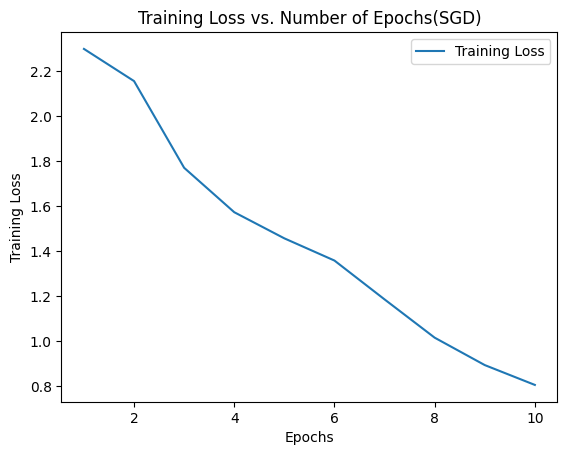

In [ ]:
# Plot training loss vs. number of epochs
plt.plot(range(1, 11), my_model_sgd.train_loss_sgd, label='Training Loss')
plt.title('Training Loss vs. Number of Epochs(SGD)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [ ]:
#for 'mgd'

my_model_momentum = Network(neuron_sizes, 'xavier', 'sigmoid', 0.9)

#envoking the function train_momentum

my_model_momentum.train_momentum(x_train, y_train, 0.01, 30, 128)

Epoch Number 1, validation accuracy: 0.7585
Epoch Number 2, validation accuracy: 0.8000
Epoch Number 3, validation accuracy: 0.7901
Epoch Number 4, validation accuracy: 0.7777
Epoch Number 5, validation accuracy: 0.8212
Epoch Number 6, validation accuracy: 0.8088
Epoch Number 7, validation accuracy: 0.8337
Epoch Number 8, validation accuracy: 0.8113
Epoch Number 9, validation accuracy: 0.8105
Epoch Number 10, validation accuracy: 0.8230
Epoch Number 11, validation accuracy: 0.8412
Epoch Number 12, validation accuracy: 0.8389
Epoch Number 13, validation accuracy: 0.8200
Epoch Number 14, validation accuracy: 0.8248
Epoch Number 15, validation accuracy: 0.8334
Epoch Number 16, validation accuracy: 0.8417
Epoch Number 17, validation accuracy: 0.8358
Epoch Number 18, validation accuracy: 0.8459
Epoch Number 19, validation accuracy: 0.8398
Epoch Number 20, validation accuracy: 0.8369
Epoch Number 21, validation accuracy: 0.8339
Epoch Number 22, validation accuracy: 0.8371
Epoch Number 23, va

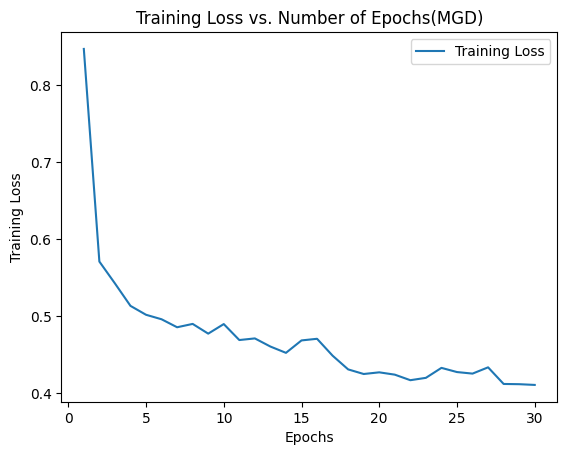

In [ ]:
# Plot training loss vs. number of epochs
plt.plot(range(1, 31), my_model_momentum.train_loss_momentum, label='Training Loss')
plt.title('Training Loss vs. Number of Epochs(MGD)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [3]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [4]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [5]:
wandb.login(key='9c44888af978d4e71b8431115bfca39a706d30d5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
# You need to define a config file in the form of dictionary or yaml
sweep_config = {
    'method': 'grid',
    'name' : 'sweep test1',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
        'optimizer': {
            'values':['sgd', 'momentum', 'nestrov']
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'batch_size': {
            'values':[16,32,64]
        },
        'learning_rate': {
            'values':[1e-3, 1e-4]
        },
        'weight_init': {
           'values' :['random', 'xavier']
        },
        'activation': {
            'values': ['sigmoid']
        },
        'loss': {
            'values': ['cross_entropy']
        },


    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment1')

Create sweep with ID: g8mfiw5c
Sweep URL: https://wandb.ai/demo17/DL_Assignment1/sweeps/g8mfiw5c


In [ ]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''


    with wandb.init() as run:

        run_name="-ac_"+wandb.config.activation+"-hs"+str(wandb.config.hidden_size)+'-wi'+wandb.config.weight_init+'-hl'+str(wandb.config.hidden_layers)+'-op'+wandb.config.optimizer+'-ep'+str(wandb.config.epochs)+'lr'+str(wandb.config.learning_rate)+'bs'+str(wandb.config.batch_size)
        wandb.run.name=run_name
        #obj=NN(wandb.config['num_layers'],wandb.config['hidden_size'])

        model = Network([784,wandb.config.hidden_size,10], wandb.config.weight_init, wandb.config.activation, 0.9)

        if wandb.config.optimizer == 'nestrov':
          model.train_nag(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        if wandb.config.optimizer == 'momentum':
          model.train_momentum(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        if wandb.config.optimizer == 'sgd':
          model.train_sgd(x_train, y_train, wandb.config.learning_rate, wandb.config.epochs, wandb.config.batch_size)
        #model.train_momentum(x_train, y_train, 0.01, 30, 128)
        #criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(model.parameters(), lr=0.01,betas=(0.9, 0.999))
        #model.train( model,criterion,optimizer,x_train,y_train,x_val,y_val)


wandb.agent(sweep_id, function=main,count=50) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: 0bmx2wsj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6378
Epoch Number 2, validation accuracy: 0.6899
Epoch Number 3, validation accuracy: 0.7139
Epoch Number 4, validation accuracy: 0.7362
Epoch Number 5, validation accuracy: 0.7480
Test Accuracy: 0.7408


val-accuracy,▁▄▆▇█
val-accuracy,74.8


wandb: Agent Starting Run: u241blu1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.5633
Epoch Number 2, validation accuracy: 0.7033
Epoch Number 3, validation accuracy: 0.7297
Epoch Number 4, validation accuracy: 0.7697
Epoch Number 5, validation accuracy: 0.8042
Test Accuracy: 0.7924


val-accuracy,▁▅▆▇█
val-accuracy,80.42


wandb: Agent Starting Run: h0aj6x6v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7702
Epoch Number 2, validation accuracy: 0.7978
Epoch Number 3, validation accuracy: 0.8082
Epoch Number 4, validation accuracy: 0.8160
Epoch Number 5, validation accuracy: 0.8214
Test Accuracy: 0.8191


val-accuracy,▁▅▆▇█
val-accuracy,82.14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lp2y54hs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.8208
Epoch Number 2, validation accuracy: 0.8364
Epoch Number 3, validation accuracy: 0.8478
Epoch Number 4, validation accuracy: 0.8524
Epoch Number 5, validation accuracy: 0.8565
Test Accuracy: 0.8524


val-accuracy,▁▄▆▇█
val-accuracy,85.65


wandb: Agent Starting Run: knkjmesr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6225
Epoch Number 2, validation accuracy: 0.6921
Epoch Number 3, validation accuracy: 0.7180
Epoch Number 4, validation accuracy: 0.7336
Epoch Number 5, validation accuracy: 0.7475
Test Accuracy: 0.7340


val-accuracy,▁▅▆▇█
val-accuracy,74.75


wandb: Agent Starting Run: un0w3e9o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4762
Epoch Number 2, validation accuracy: 0.6888
Epoch Number 3, validation accuracy: 0.7266
Epoch Number 4, validation accuracy: 0.7646
Epoch Number 5, validation accuracy: 0.8048
Test Accuracy: 0.8009


val-accuracy,▁▆▆▇█
val-accuracy,80.48


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uov3zow8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.2013
Epoch Number 2, validation accuracy: 0.3307
Epoch Number 3, validation accuracy: 0.4289
Epoch Number 4, validation accuracy: 0.4784
Epoch Number 5, validation accuracy: 0.5100
Test Accuracy: 0.5161


val-accuracy,▁▄▆▇█
val-accuracy,51.0


wandb: Agent Starting Run: hgk8ycub with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1005
Epoch Number 2, validation accuracy: 0.1150
Epoch Number 3, validation accuracy: 0.1565
Epoch Number 4, validation accuracy: 0.1893
Epoch Number 5, validation accuracy: 0.2484
Test Accuracy: 0.2487


val-accuracy,▁▂▄▅█
val-accuracy,24.84


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bkbfyr0e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6207
Epoch Number 2, validation accuracy: 0.6767
Epoch Number 3, validation accuracy: 0.7037
Epoch Number 4, validation accuracy: 0.7185
Epoch Number 5, validation accuracy: 0.7293
Test Accuracy: 0.7293


val-accuracy,▁▅▆▇█
val-accuracy,72.93


wandb: Agent Starting Run: qptch6dx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4360
Epoch Number 2, validation accuracy: 0.6420
Epoch Number 3, validation accuracy: 0.7511
Epoch Number 4, validation accuracy: 0.7707
Epoch Number 5, validation accuracy: 0.7846
Test Accuracy: 0.7770


val-accuracy,▁▅▇██
val-accuracy,78.46


wandb: Agent Starting Run: vt82m1tf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.2737
Epoch Number 2, validation accuracy: 0.4244
Epoch Number 3, validation accuracy: 0.4979
Epoch Number 4, validation accuracy: 0.5325
Epoch Number 5, validation accuracy: 0.5543
Test Accuracy: 0.5513


val-accuracy,▁▅▇▇█
val-accuracy,55.43


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: elmb1671 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1044
Epoch Number 2, validation accuracy: 0.1584
Epoch Number 3, validation accuracy: 0.2020
Epoch Number 4, validation accuracy: 0.2543
Epoch Number 5, validation accuracy: 0.3568
Test Accuracy: 0.3538


val-accuracy,▁▂▄▅█
val-accuracy,35.68


wandb: Agent Starting Run: k0ztvwn7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6483
Epoch Number 2, validation accuracy: 0.7026
Epoch Number 3, validation accuracy: 0.7302
Epoch Number 4, validation accuracy: 0.7442
Epoch Number 5, validation accuracy: 0.7519
Test Accuracy: 0.7536


val-accuracy,▁▅▇▇█
val-accuracy,75.19


wandb: Agent Starting Run: que0u683 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4670
Epoch Number 2, validation accuracy: 0.7131
Epoch Number 3, validation accuracy: 0.7736
Epoch Number 4, validation accuracy: 0.8021
Epoch Number 5, validation accuracy: 0.8183
Test Accuracy: 0.8081


val-accuracy,▁▆▇██
val-accuracy,81.83


wandb: Agent Starting Run: 2ikst413 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7674
Epoch Number 2, validation accuracy: 0.7951
Epoch Number 3, validation accuracy: 0.8086
Epoch Number 4, validation accuracy: 0.8191
Epoch Number 5, validation accuracy: 0.8250
Test Accuracy: 0.8241


val-accuracy,▁▄▆▇█
val-accuracy,82.5


wandb: Agent Starting Run: zg1tdy45 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.8205
Epoch Number 2, validation accuracy: 0.8415
Epoch Number 3, validation accuracy: 0.8546
Epoch Number 4, validation accuracy: 0.8582
Epoch Number 5, validation accuracy: 0.8605
Test Accuracy: 0.8550


val-accuracy,▁▅▇██
val-accuracy,86.05


wandb: Agent Starting Run: kgrliddc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6700
Epoch Number 2, validation accuracy: 0.7141
Epoch Number 3, validation accuracy: 0.7359
Epoch Number 4, validation accuracy: 0.7484
Epoch Number 5, validation accuracy: 0.7568
Test Accuracy: 0.7487


val-accuracy,▁▅▆▇█
val-accuracy,75.68


wandb: Agent Starting Run: rsdfiqs8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4321
Epoch Number 2, validation accuracy: 0.6998
Epoch Number 3, validation accuracy: 0.7437
Epoch Number 4, validation accuracy: 0.7708
Epoch Number 5, validation accuracy: 0.7916
Test Accuracy: 0.7847


val-accuracy,▁▆▇██
val-accuracy,79.16


wandb: Agent Starting Run: whptwm47 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.3547
Epoch Number 2, validation accuracy: 0.4642
Epoch Number 3, validation accuracy: 0.5197
Epoch Number 4, validation accuracy: 0.5598
Epoch Number 5, validation accuracy: 0.5881
Test Accuracy: 0.5877


val-accuracy,▁▄▆▇█
val-accuracy,58.81


wandb: Agent Starting Run: udblzhs1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1423
Epoch Number 2, validation accuracy: 0.1819
Epoch Number 3, validation accuracy: 0.1862
Epoch Number 4, validation accuracy: 0.2037
Epoch Number 5, validation accuracy: 0.2317
Test Accuracy: 0.2308


val-accuracy,▁▄▄▆█
val-accuracy,23.17


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0i6l6g0f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6649
Epoch Number 2, validation accuracy: 0.7126
Epoch Number 3, validation accuracy: 0.7346
Epoch Number 4, validation accuracy: 0.7452
Epoch Number 5, validation accuracy: 0.7554
Test Accuracy: 0.7499


val-accuracy,▁▅▆▇█
val-accuracy,75.54


wandb: Agent Starting Run: m5n59yu4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.5057
Epoch Number 2, validation accuracy: 0.7050
Epoch Number 3, validation accuracy: 0.7455
Epoch Number 4, validation accuracy: 0.7733
Epoch Number 5, validation accuracy: 0.8051
Test Accuracy: 0.7943


val-accuracy,▁▆▇▇█
val-accuracy,80.51


wandb: Agent Starting Run: qwlm85sp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.3022
Epoch Number 2, validation accuracy: 0.4765
Epoch Number 3, validation accuracy: 0.5432
Epoch Number 4, validation accuracy: 0.5788
Epoch Number 5, validation accuracy: 0.6029
Test Accuracy: 0.6005


val-accuracy,▁▅▇▇█
val-accuracy,60.29


wandb: Agent Starting Run: 7aqqe9na with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1037
Epoch Number 2, validation accuracy: 0.1999
Epoch Number 3, validation accuracy: 0.2166
Epoch Number 4, validation accuracy: 0.2209
Epoch Number 5, validation accuracy: 0.2847
Test Accuracy: 0.2864


val-accuracy,▁▅▅▆█
val-accuracy,28.47


wandb: Agent Starting Run: 4198tvtz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7060
Epoch Number 2, validation accuracy: 0.7439
Epoch Number 3, validation accuracy: 0.7653
Epoch Number 4, validation accuracy: 0.7764
Epoch Number 5, validation accuracy: 0.7835
Test Accuracy: 0.7817


val-accuracy,▁▄▆▇█
val-accuracy,78.35


wandb: Agent Starting Run: 0iauv25t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4058
Epoch Number 2, validation accuracy: 0.6619
Epoch Number 3, validation accuracy: 0.7149
Epoch Number 4, validation accuracy: 0.7556
Epoch Number 5, validation accuracy: 0.7842
Test Accuracy: 0.7747


val-accuracy,▁▆▇▇█
val-accuracy,78.42


wandb: Agent Starting Run: 6wkn2fs6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7804
Epoch Number 2, validation accuracy: 0.7965
Epoch Number 3, validation accuracy: 0.8051
Epoch Number 4, validation accuracy: 0.8121
Epoch Number 5, validation accuracy: 0.8189
Test Accuracy: 0.8148


val-accuracy,▁▄▅▇█
val-accuracy,81.89


wandb: Agent Starting Run: ambu1pv8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.8241
Epoch Number 2, validation accuracy: 0.8428
Epoch Number 3, validation accuracy: 0.8507
Epoch Number 4, validation accuracy: 0.8573
Epoch Number 5, validation accuracy: 0.8597
Test Accuracy: 0.8539


val-accuracy,▁▅▆██
val-accuracy,85.97


wandb: Agent Starting Run: 11zn3gh1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7047
Epoch Number 2, validation accuracy: 0.7426
Epoch Number 3, validation accuracy: 0.7586
Epoch Number 4, validation accuracy: 0.7710
Epoch Number 5, validation accuracy: 0.7782
Test Accuracy: 0.7709


val-accuracy,▁▅▆▇█
val-accuracy,77.82


wandb: Agent Starting Run: i6vxsmak with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4637
Epoch Number 2, validation accuracy: 0.6368
Epoch Number 3, validation accuracy: 0.7104
Epoch Number 4, validation accuracy: 0.7343
Epoch Number 5, validation accuracy: 0.7831
Test Accuracy: 0.7719


val-accuracy,▁▅▆▇█
val-accuracy,78.31


wandb: Agent Starting Run: 87q5v8uw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.4315
Epoch Number 2, validation accuracy: 0.5529
Epoch Number 3, validation accuracy: 0.6072
Epoch Number 4, validation accuracy: 0.6383
Epoch Number 5, validation accuracy: 0.6625
Test Accuracy: 0.6529


val-accuracy,▁▅▆▇█
val-accuracy,66.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lacan3ny with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1537
Epoch Number 2, validation accuracy: 0.1995
Epoch Number 3, validation accuracy: 0.2083
Epoch Number 4, validation accuracy: 0.2332
Epoch Number 5, validation accuracy: 0.3444
Test Accuracy: 0.3519


val-accuracy,▁▃▃▄█
val-accuracy,34.44


wandb: Agent Starting Run: t3emn4rg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6954
Epoch Number 2, validation accuracy: 0.7406
Epoch Number 3, validation accuracy: 0.7579
Epoch Number 4, validation accuracy: 0.7677
Epoch Number 5, validation accuracy: 0.7733
Test Accuracy: 0.7718


val-accuracy,▁▅▇▇█
val-accuracy,77.33


wandb: Agent Starting Run: ur0zdmjp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.4487
Epoch Number 2, validation accuracy: 0.6568
Epoch Number 3, validation accuracy: 0.7174
Epoch Number 4, validation accuracy: 0.7591
Epoch Number 5, validation accuracy: 0.7802
Test Accuracy: 0.7685


val-accuracy,▁▅▇██
val-accuracy,78.02


wandb: Agent Starting Run: qxp3m67a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.4536
Epoch Number 2, validation accuracy: 0.5490
Epoch Number 3, validation accuracy: 0.5986
Epoch Number 4, validation accuracy: 0.6263
Epoch Number 5, validation accuracy: 0.6451
Test Accuracy: 0.6352


val-accuracy,▁▄▆▇█
val-accuracy,64.51


wandb: Agent Starting Run: h055mm2s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.1196
Epoch Number 2, validation accuracy: 0.1736
Epoch Number 3, validation accuracy: 0.1622
Epoch Number 4, validation accuracy: 0.2308
Epoch Number 5, validation accuracy: 0.2983
Test Accuracy: 0.3034


val-accuracy,▁▃▃▅█
val-accuracy,29.83


wandb: Agent Starting Run: mltymkq7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6138
Epoch Number 2, validation accuracy: 0.6789
Epoch Number 3, validation accuracy: 0.7120
Epoch Number 4, validation accuracy: 0.7289
Epoch Number 5, validation accuracy: 0.7388
Test Accuracy: 0.7316


val-accuracy,▁▅▆▇█
val-accuracy,73.88


wandb: Agent Starting Run: rg3z7dlh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.5215
Epoch Number 2, validation accuracy: 0.7510
Epoch Number 3, validation accuracy: 0.7855
Epoch Number 4, validation accuracy: 0.8111
Epoch Number 5, validation accuracy: 0.8227
Test Accuracy: 0.8141


val-accuracy,▁▆▇██
val-accuracy,82.27


wandb: Agent Starting Run: bkuu8d4c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.7763
Epoch Number 2, validation accuracy: 0.7993
Epoch Number 3, validation accuracy: 0.8132
Epoch Number 4, validation accuracy: 0.8182
Epoch Number 5, validation accuracy: 0.8252
Test Accuracy: 0.8171


val-accuracy,▁▄▆▇█
val-accuracy,82.52


wandb: Agent Starting Run: 6q1msemm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.8283
Epoch Number 2, validation accuracy: 0.8423
Epoch Number 3, validation accuracy: 0.8483
Epoch Number 4, validation accuracy: 0.8541
Epoch Number 5, validation accuracy: 0.8560
Test Accuracy: 0.8486


val-accuracy,▁▅▆██
val-accuracy,85.6


wandb: Agent Starting Run: nsbazf4y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.6383
Epoch Number 2, validation accuracy: 0.7011
Epoch Number 3, validation accuracy: 0.7227
Epoch Number 4, validation accuracy: 0.7390
Epoch Number 5, validation accuracy: 0.7471
Test Accuracy: 0.7454


val-accuracy,▁▅▆▇█
val-accuracy,74.71


wandb: Agent Starting Run: 2sghimu1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimizer: nestrov
wandb: 	weight_init: xavier


Epoch Number 1, validation accuracy: 0.6391
Epoch Number 2, validation accuracy: 0.7148
Epoch Number 3, validation accuracy: 0.7435
Epoch Number 4, validation accuracy: 0.7833
Epoch Number 5, validation accuracy: 0.8163
Test Accuracy: 0.8050


val-accuracy,▁▄▅▇█
val-accuracy,81.63


wandb: Agent Starting Run: ujerzruu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch Number 1, validation accuracy: 0.3175
Epoch Number 2, validation accuracy: 0.4555
Epoch Number 3, validation accuracy: 0.5205
Epoch Number 4, validation accuracy: 0.5620
Epoch Number 5, validation accuracy: 0.5853
Test Accuracy: 0.5737


val-accuracy,▁▅▆▇█
val-accuracy,58.53


wandb: Agent Starting Run: 7ctw1ktf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
